In [1]:
# Loading libraries
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
import xesmf as xe
import dask
import season_util as su
import jetlatcalcs as jlat

you have successfully imported the jet latitude calculation subroutines


In [3]:
from ncar_jobqueue import NCARCluster
from distributed import Client
cluster = NCARCluster(project='P04010022')
cluster.adapt(minimum_jobs=1, maximum_jobs=10)
client = Client(cluster)
cluster

/ncar/usr/jupyterhub/envs/cmip6-201910/lib/python3.7/site-packages/distributed/dashboard/core.py:72: UserWarning: 
Port 8787 is already in use. 
Perhaps you already have a cluster running?
Hosting the diagnostics dashboard on a random port instead.
  warnings.warn("\n" + msg)


In [5]:
#historical simulations
import intake
var= ["ua"]
model=['AWI-CM-1-MR','BCC-CSM2-MR','CAMS-CSM1-0','CanESM5','MIROC-ES2L','MIROC6','UKESM1-0-LL','MRI-ESM2-0']
col = intake.open_esm_datastore("/glade/collections/cmip/catalog/intake-esm-datastore/catalogs/glade-cmip6.json")
cat = col.search(activity_id="CMIP",experiment_id="historical", variable_id=var,
table_id="Amon", grid_label="gn", source_id=model )
dset_dict_hist = cat.to_dataset_dict(cdf_kwargs={'chunks': {"time": 36}, 
                                    'decode_times': True})

--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'

--> There will be 7 group(s)


In [7]:
#ssp simulations
col = intake.open_esm_datastore("/glade/collections/cmip/catalog/intake-esm-datastore/catalogs/glade-cmip6.json")
cat = col.search(activity_id="ScenarioMIP",experiment_id="ssp370", variable_id=var,
table_id="Amon", grid_label="gn", source_id=model )
dset_dict_ssp370 = cat.to_dataset_dict(cdf_kwargs={'chunks': {"time": 36}, 
                                    'decode_times': True})

--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'

--> There will be 7 group(s)


In [11]:
#calculate the mean over longitude, ensemble members and desired time period and pick out 700hPa
hist_mean = {}
for key, ds in dset_dict_hist.items():
    hist_mean[key] = ds.sel(time = slice('1979-01-01','2006-01-01'), plev=70000.).mean(dim=["member_id","lon"])
    
ssp370_mean = {}
for key, ds in dset_dict_ssp370.items():
    ssp370_mean[key] = ds.sel(time = slice('2070-01-01','2099-01-01'), plev=70000.).mean(dim=["member_id","lon"])

In [13]:
hist_mean = dask.compute(hist_mean)
ssp370_mean = dask.compute(ssp370_mean)

In [16]:
# calculate JJA season average
hist_jja = {}
for key, x in dset_dict_hist.items():
    hist_jja[key] = su.season_mean(hist_mean[0][key],"ua",season="JJA")
    
ssp370_jja = {}
for key, x in dset_dict_ssp370.items():
    ssp370_jja[key] = su.season_mean(ssp370_mean[0][key],"ua",season="JJA")

In [20]:
#calculate jet latitude
jlathist = {}
jspeedhist = {}
for key, x in dset_dict_hist.items():
    jlatv, jspeedv = jlat.calcjetlat( hist_jja[key], -80, -20)
    jlathist[key] = jlatv
    jspeedhist[key] = jspeedv
    
jlatssp370 = {}
jspeedssp370 = {}
for key, x in dset_dict_ssp370.items():
    jlatv, jspeedv = jlat.calcjetlat( ssp370_jja[key], -80, -20)
    jlatssp370[key] = jlatv
    jspeedssp370[key] = jspeedv

In [86]:
#read in cmip5 data
cmip5path = "../data/cmip5_jetlatitudes.nc"
cmip5 = xr.open_dataset(cmip5path)
#calculate linear regression line
coefs = np.polyfit(cmip5.jlatpast, cmip5.jlatfuture - cmip5.jlatpast, 1)
acmip5=coefs[1]
bcmip5=coefs[0]
xvalues = [i for i in range(-55,-35)]
yvalues = [acmip5 + bcmip5*i for i in xvalues]

In [91]:
#predict cmip6 values from cmip5
jlathistvalues = list(jlathist.values())
ycmip6 = [acmip5 + bcmip5*i for i in jlathistvalues]
ycmip6

[-0.7916270928244344,
 -2.558254102697484,
 -1.781592515168409,
 -6.1181011118662045,
 -4.856125117373274,
 -2.0160214852062204,
 -2.8111764114547597]

Text(0.5, 1.0, '$\\Delta\\phi$ prediction vs $\\Delta\\phi$')

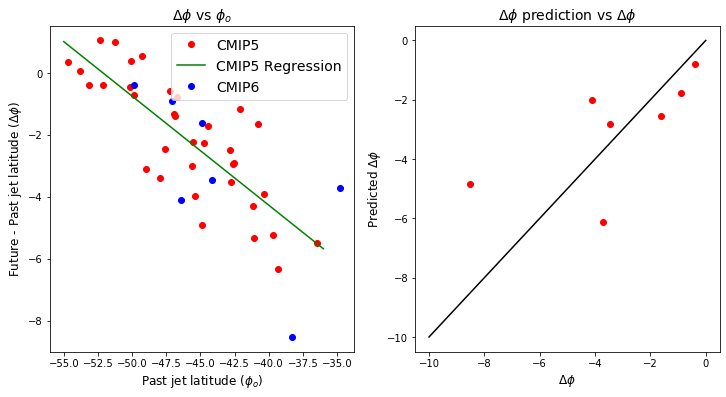

In [109]:
# plotting
jlathistvalues = list(jlathist.values())
jlatssp370values = list(jlatssp370.values())
jlatdif = [a - b for a, b in zip(jlatssp370values, jlathistvalues)]
jlatdifpredict = [acmip5 + bcmip5*i for i in jlathistvalues]
fig = plt.figure(figsize=(12, 6),facecolor='w')
ax = fig.add_subplot(1, 2, 1)
#ax.plot(jlathistvalues,jlatdif, color='red', label='CMIP6', marker='o', linestyle='none')
ax.plot(cmip5.jlatpast, cmip5.jlatfuture-cmip5.jlatpast, color='red', label='CMIP5', marker='o', linestyle='none')
ax.plot(xvalues,yvalues,color='green', label='CMIP5 Regression', linestyle='solid')
ax.plot(jlathistvalues,jlatdif, color='blue', label='CMIP6', marker='o', linestyle='none')
ax.set_xlabel('Past jet latitude ($\phi_{o}$)', fontdict={'size':12});
ax.set_ylabel('Future - Past jet latitude ($\Delta\phi$)', fontdict={'size':12});  
ax.set_title('$\Delta\phi$ vs $\phi_{o}$', fontdict={'size':14})
ax.legend(loc='upper right', fontsize=14)

ax2=fig.add_subplot(1,2,2)
ax2.plot(jlatdif, jlatdifpredict, color='red', label='CMIP5', marker='o', linestyle='none')
ax2.set_xlabel('$\Delta\phi$', fontdict={'size':12})
ax2.set_ylabel('Predicted $\Delta\phi$', fontdict={'size':12})
ax2.plot([-10,0],[-10,0], color='black', label='1:1', linestyle='solid')
ax2.set_title('$\Delta\phi$ prediction vs $\Delta\phi$', fontdict={'size':14})
#fig = plt.figure(figsize=(6, 6),facecolor='w')
#ax = fig.add_subplot(1, 1, 1)